In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Sean Holman (University of Manchester), Gemma Fardell (STFC-UKRI), Margaret Duff (STFC-UKRI)

In [2]:
#Import a large number of libraries to help!

from cil.optimisation.functions import Function, LeastSquares, ZeroFunction
from cil.optimisation.functions import OperatorCompositionFunction

from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import BlockFunction, MixedL21Norm, L2NormSquared, SmoothMixedL21Norm
from cil.optimisation.operators import BlockOperator, GradientOperator


# CIL core components needed
from cil.framework import ImageGeometry, AcquisitionGeometry, BlockDataContainer, AcquisitionData

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import FISTA, ISTA
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

# CIL example synthetic test image
from cil.utilities.dataexample import SHAPES

# CIL display tools
from cil.utilities.display import show2D, show1D, show_geometry

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# For shepp-logan test image in CIL tomophantom plugin
from cil.plugins import TomoPhantom as cilTomoPhantom

# Third-party imports
import numpy as np    
import matplotlib.pyplot as plt

# Multibang Regularisation in CIL

This notebook implements the multibang regulariser described in [1] as a "Function" in CIL that includes a proximal map. It then uses this function to analyze both synthetic CT data (the Shepp-Logan phantom) and some of the cone beam CT training data from the Helsinki 2022 limited angle tomography challenge.

Upon instantiation, the multibang function must include an np.array of dimension (n,) as `u = np.array([...])` which gives the list of multibang values. These are target values, and the multibang function penalises any value in an image which is not on the list.

There appears to be in error in the function call which results in it returning a value of `-inf` in some cases. This does not affect the proximal map but does mean that the objective function is sometimes incorrectly given a value `-inf`.

### Reference

[1] *SPECT with a multi-bang assumption on attenuation*, Sean Holman and Philip Richardson, 2020 Inverse Problems, (**36**)12. 



### CIL Version 23.0.1

In [3]:
import cil
print(cil.__version__)

23.0.1


### THe dataset 

This requires the dataset ""htc2022_tf_full.mat" from https://zenodo.org/record/6984868:

- https://zenodo.org/record/6984868/files/htc2022_td_full.mat

Please download the data and update the 'filename' variable below to point to where you have the data saved:

In [4]:
filename='../htc2022_td_full.mat'

## Define the regularisation function 

Define the multibang class for objective function, includes function call and proximal map.

Required input for initialisation is u = np.array([...]) a list of multibang values.  



In [5]:
class Multbang(Function):
    
    def __init__(self,**kwargs):
        
        utemp = np.sort(kwargs.get('u'))
        #self.u = np.concatenate(([-np.inf],utemp,[np.inf]))
        
        self.u = utemp #u should be numpty array
    
    def convex_conjugate(self, x):
        return 0.0
    
    def __call__(self,x):
        
        u = self.u
        Max = u.max()
        utemp = np.concatenate(([-np.inf],u,[np.inf]))
        su = utemp.shape
        sx = x.shape
        ru = utemp.reshape(np.concatenate(([1,1],su)))
        t = x.as_array()
        rx = t.reshape(np.concatenate((sx,[1])))
        uval = np.sum(ru<=rx,axis=2)
        uval = uval-(x==Max)
        uL = utemp[uval-1]
        uR = utemp[uval]
        m = (uR-t)*(t-uL)
        m[m==np.nan] = np.inf
        return np.sum(m)
    
    def proximal(self,x, t, out=None):
        
        #t is step size, must be <1/2.
        
        y = x*0
        u = self.u
        k = u.size
        xm = np.concatenate(([-np.inf],(1-t)*u[1:k]+t*u[0:(k-1)]))
        xm = xm.reshape(np.array([1,1,k]))
        xp = np.concatenate(((1-t)*u[0:k-1]+t*u[1:k],[np.inf]))
        xp = xp.reshape(np.array([1,1,k]))
        ax = x.as_array()
        sx = x.shape
        rx = ax.reshape(np.concatenate((sx,[1])))
        uvalm = np.sum(xm<rx,axis=2)
        uvalp = np.sum(xp<rx,axis=2)
        temp = uvalp<uvalm
        arr = np.zeros(sx)
        arr[temp] = u[uvalp[temp]]
        arr[~temp] = 1/(1-2*t)*(ax[~temp]-t*(u[uvalp[~temp]-1]+u[uvalp[~temp]]))
        
        y.fill(arr)
        
        if out is None:
            return y
        else:
            out.fill(y)

An example instantiating a multibang function with the multibang values that appear in the Shepp-Logan phantom. Note that the multibang values do not need to be sorted.

In [6]:
MB = Multbang(u=np.array([0,0.1,0.2,0.3,0.4,1]))

## Example using Shepp-Logan phantom

We first look at application of the multibang regulariser to the Shepp-Logan phantom with a limited number of projection angles. To begin we get the phantom and create a synthetic sinogram.

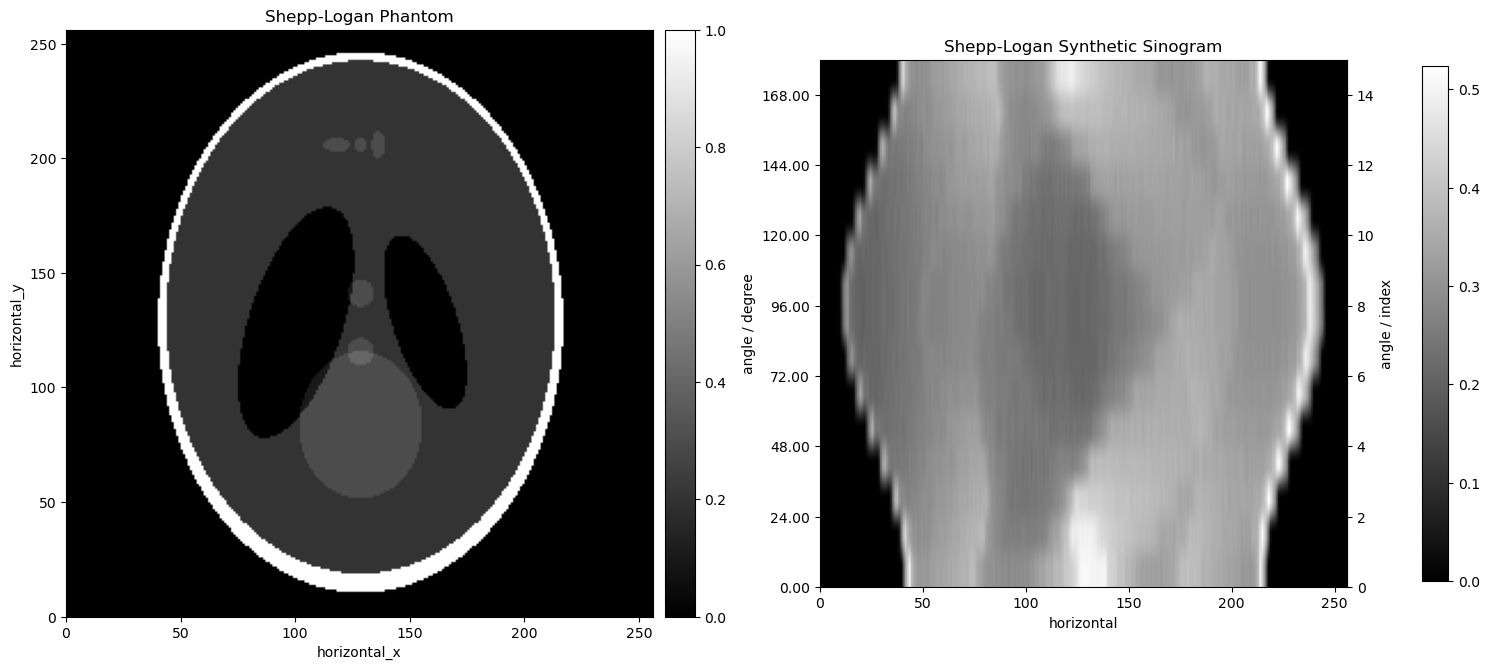

In [7]:
# Create phantom and synthetic sinogram

n = 256
ig = ImageGeometry(voxel_num_x=n, 
                   voxel_num_y=n, 
                   voxel_size_x=2/n, 
                   voxel_size_y=2/n)

phantom2D = cilTomoPhantom.get_ImageData(num_model=1, geometry=ig)

# You may want to try varying the number of angles

num_angles = 15
ag = AcquisitionGeometry.create_Parallel2D()  \
                   .set_angles(np.linspace(0, 180, num_angles, endpoint=False))  \
                   .set_panel(n, 2/n)

device = "gpu"
A = ProjectionOperator(ig, ag, device)

sinogram = A.direct(phantom2D)

show2D([phantom2D,sinogram],title=["Shepp-Logan Phantom","Shepp-Logan Synthetic Sinogram"])

To avoid inverse crime, we add some noise to the phantom.

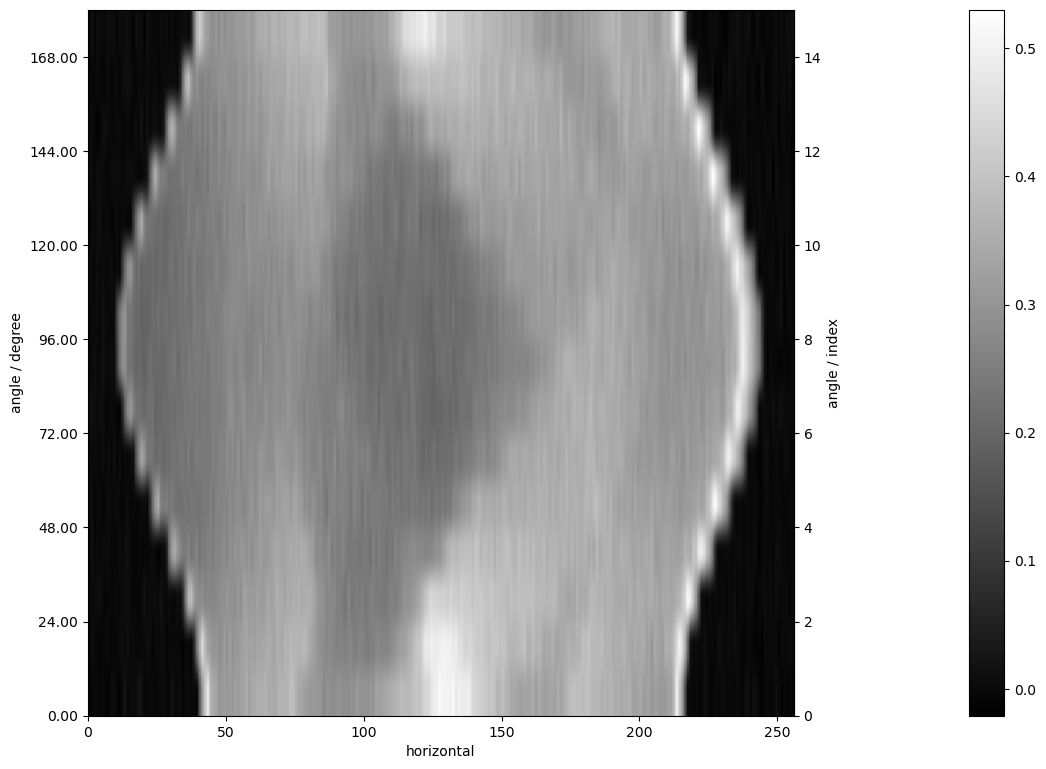

In [8]:
#Add noise to phantom

# Incident intensity: lower counts will increase the noise
background_counts = 20000

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sinogram.as_array())
noisy_counts = np.random.poisson(counts)
sino_out = -np.log(noisy_counts/background_counts)

# Create new AcquisitionData object with same geometry and fill with noisy data.
sinogram_noisy = ag.allocate()
sinogram_noisy.fill(sino_out)
show2D(sinogram_noisy)

Now we set up FISTA to run on the Shepp-Logan phantom synthetic sinogram using a multibang regulariser with multibang values that appear in the Shepp-Logan phantom. The multibang results are compared with the output when FISTA is run with the zero function as regulariser, which should correspond to gradient descent.

Precisely, the FISTA algorithm is solving the variational problem

$$\mathbf{argmin}_x \|Ax - b\|^2_2 + \alpha\ \mathcal{M}(x)$$

where $A$ is the CT matrix, $b$ is the sinogram and $\mathcal{M}$ is the multibang regulariser. The result is compared against the output, from the same algorithm, of

$$\mathbf{argmin}_x \|Ax - b\|^2_2$$


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.04584e+02
      100       1000         0.035          3.42207e-02
      200       1000         0.029          2.87097e-02
-------------------------------------------------------
      200       1000         0.029          2.87097e-02
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.04584e+02
      100       1000         0.016          3.06709e-03
      200       1000         0.023          2.34225e-03
-------------------------------------------------------
      200       1000         0.023          2.34225e-03
Stop criterion has been reached.



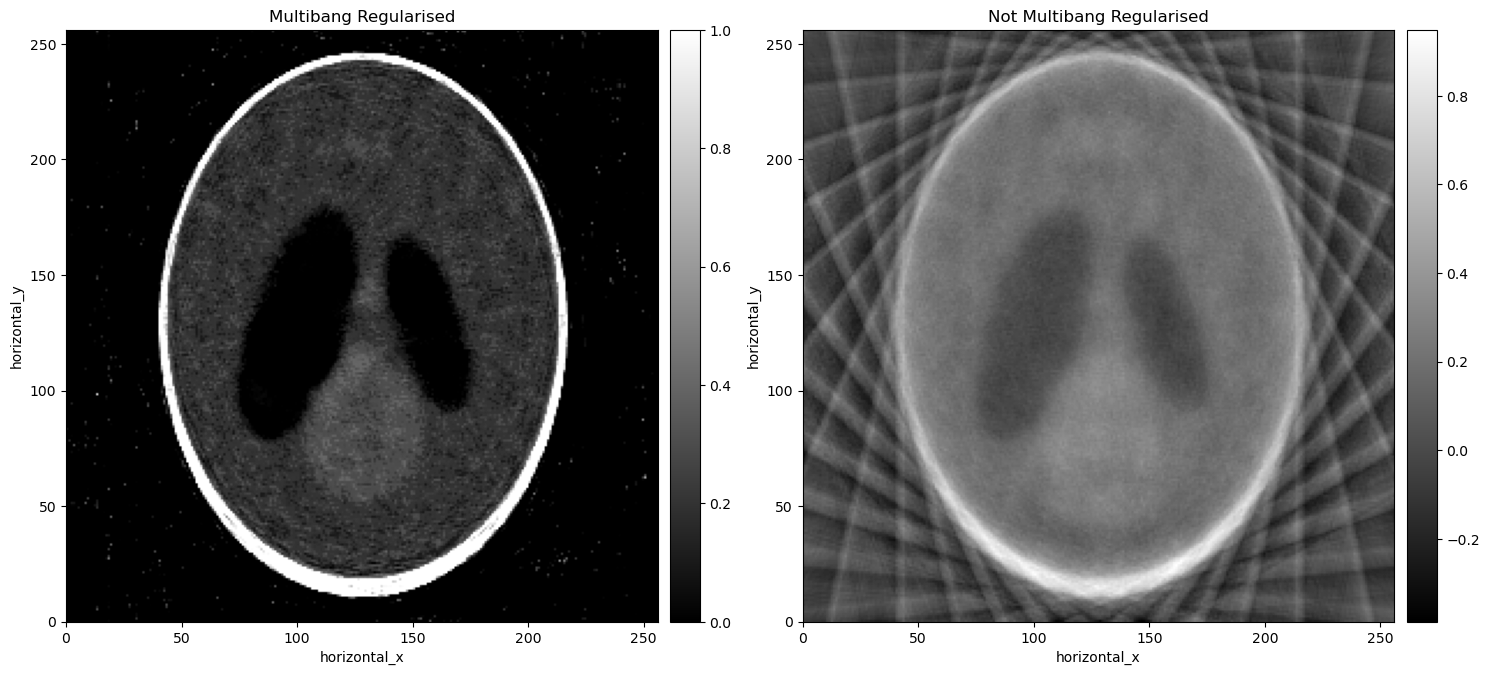

In [9]:
#Set up and run reconstruction: FISTA with multibang only

#Regularisation parameter is alpha

alpha = 0.00004

MB = Multbang(u=np.array([0,0.1,0.2,0.3,0.4,1]))
initial = ig.allocate(0)
F = LeastSquares(A,sinogram_noisy)
G = alpha*MB

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)

fista_mb.run(200,verbose=1)
MBsol = fista_mb.solution

G = ZeroFunction()
fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)

fista_mb.run(200,verbose=1)
Plainsol = fista_mb.solution

show2D([MBsol,Plainsol],title=['Multibang Regularised','Not Multibang Regularised'])

Results from the previous step suggest that total variation regularisation should also be included in the multibang reconstruction. We do this in the next step. Here the precise variational problem is

$$\mathbf{argmin}_x \|Ax - b\|^2_2 + \beta\ \|x\|_{TV_\epsilon}+ \alpha\ \mathcal{M}(x)$$

where $\|\cdot\|_{TV_\epsilon}$ is a smoothed $TV$ norm with parameter $\epsilon$. This is compared against the solution of the same problem with $\alpha = 0$. The problem is again solved using FISTA.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.04584e+02


      100       1000         0.047          7.54290e-01
      200       1000         0.032          7.36009e-01
-------------------------------------------------------
      200       1000         0.032          7.36009e-01
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.04584e+02
      100       1000         0.010          7.12630e-01
      200       1000         0.009          6.61108e-01
-------------------------------------------------------
      200       1000         0.009          6.61108e-01
Stop criterion has been reached.



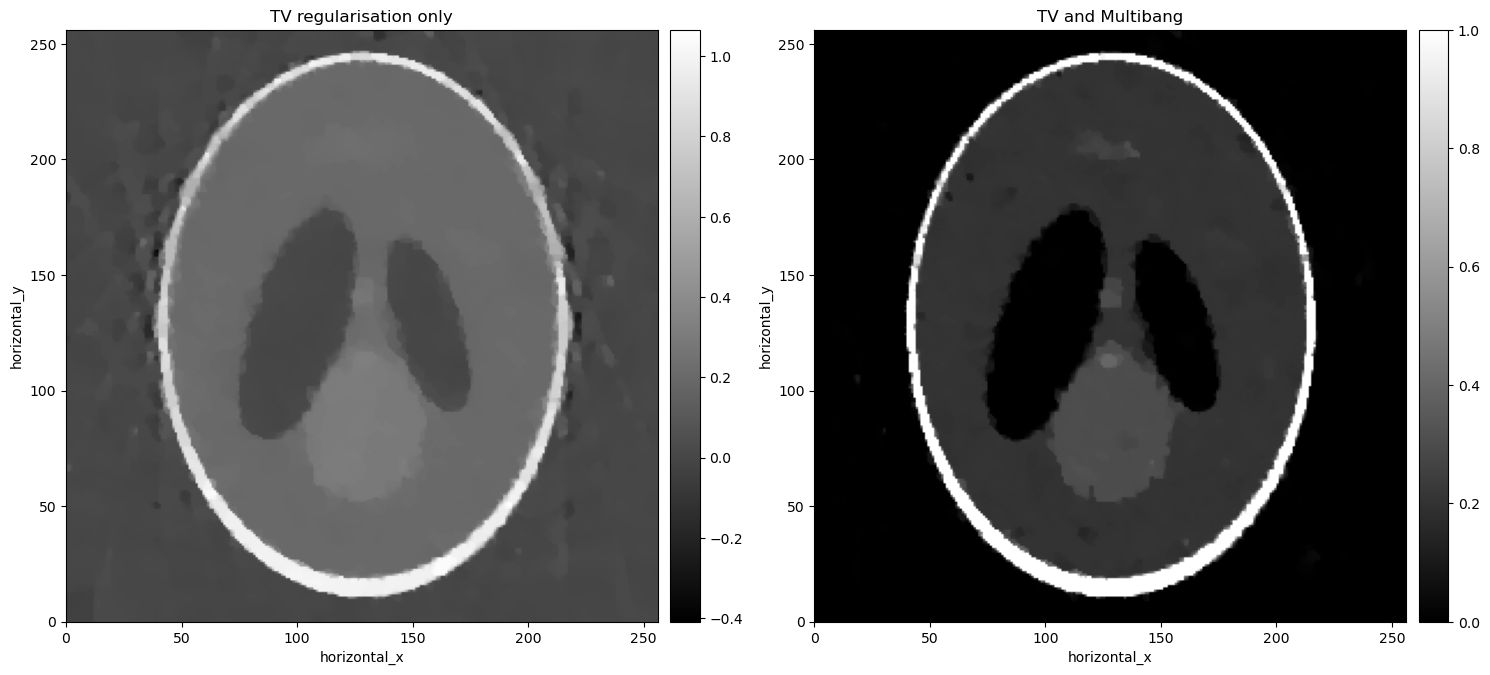

In [10]:
#FISTA with smoothed TV and multibang

Grad = GradientOperator(ig)

MB = Multbang(u=np.array([0,0.1,0.2,0.3,0.4,1]))
f1 = LeastSquares(A=A, b=sinogram_noisy,c=1.)

#Set parameters here if desired

alpha = 0.0008
beta = 0.000003
epsilon = 0.0001

f2 = beta * OperatorCompositionFunction(SmoothMixedL21Norm(epsilon), Grad)
F = f1 + f2
G = alpha*MB

initial = ig.allocate(0.0)

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)
fista_mb.run(200,verbose=1)
TVMBsol = fista_mb.solution

G = ZeroFunction()

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)
fista_mb.run(200,verbose=1)
TVsol = fista_mb.solution

show2D([TVsol,TVMBsol],title=['TV regularisation only','TV and Multibang'])

## Example using Helsinki limited angle challenge data

Next we apply multibang regularisation to cone beam training data from the 2022 Helsinki limited angle tomography challenge (HTC). The first section loads the data. Note that when the code is run some warnings will appear, but the sinogram should display when the code is run to indicate it has executed correctly. Code for loading the data is copied from the CIL github.

In [11]:
#Function to load htc data, copied from CIL github Algorthm 2.

def load_htc2022data(filename, dataset_name='CtDataFull'):

    #read in matlab file
    mat = loadmat(filename)
    scan_parameters= mat[dataset_name]['parameters']

    #read important parameters
    source_center = scan_parameters['distanceSourceOrigin']
    source_detector = scan_parameters['distanceSourceDetector']
    pixel_size = scan_parameters['pixelSizePost'] #data is binned
    num_dets = scan_parameters['numDetectorsPost']
    angles = scan_parameters['angles']

    #create CIL data from meta data
    ag = AcquisitionGeometry.create_Cone2D(source_position=[0,-source_center], 
                                        detector_position=[0,source_detector-source_center])\
        .set_panel(num_pixels=num_dets, pixel_size=pixel_size)\
        .set_angles(angles=-angles, angle_unit='degree')

    #%% read data
    scan_sinogram = mat[dataset_name]['sinogram'].astype('float32')

    #create CIL data
    
    data = AcquisitionData(np.squeeze(scan_sinogram), geometry=ag)

    return data

#Required utilities to load htc data, also copied from CIL github

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

testdata=load_htc2022data(filename)



FileNotFoundError: [Errno 2] No such file or directory: '/data/HTC/htc2022_td_full.mat'

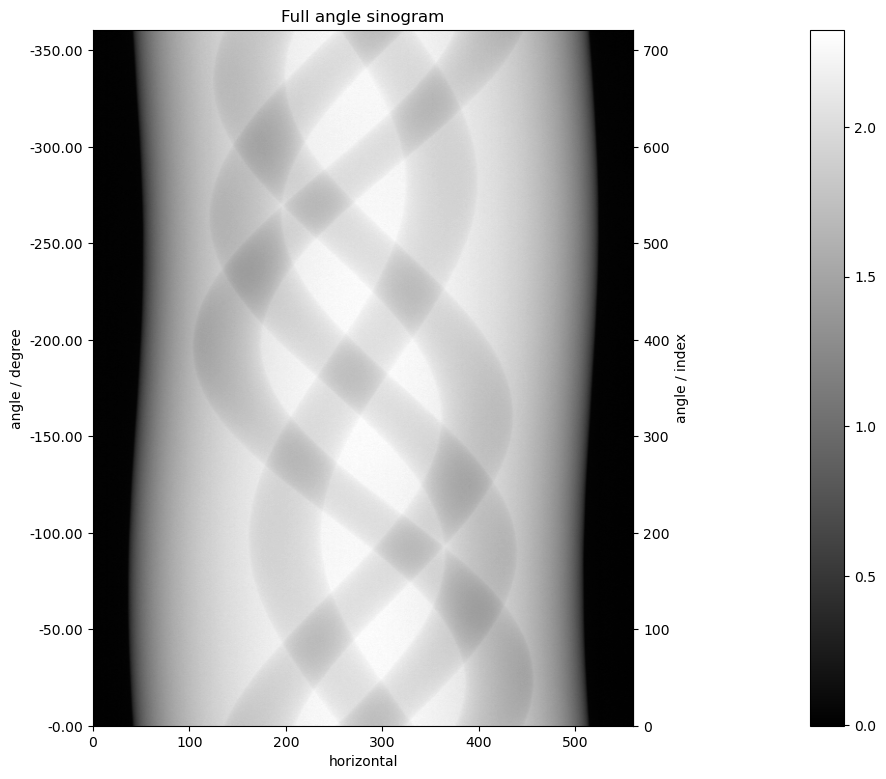

In [ ]:

#Set geometry for htc data

ig = testdata.geometry.get_ImageGeometry()
ag = testdata.geometry
devive="gpu"
A = ProjectionOperator(ig,ag,device)
Grad = GradientOperator(ig)

show2D(testdata,title=['Full angle sinogram'])

We apply the same combined TV and multibang method described above to reconstruct an image from the full data. Results with and without multibang regularisation are compared. Note that the paramters are chosen differently from above and can be changed.

The reconstructions are very similar, but you will note that in the multibang case more pixels are assigned the multibang value, which is initially set to 0.035.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.08457e+06
      100       1000         0.073          6.07662e+02
      200       1000         0.072          6.07780e+02
-------------------------------------------------------
      200       1000         0.072          6.07780e+02
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.08457e+06
      100       1000         0.049          1.79711e+02
      200       1000         0.049          1.79981e+02
-------------------------------------------------------
      200       1000         0.049          1.79981e+02
Stop criterion has been reached.



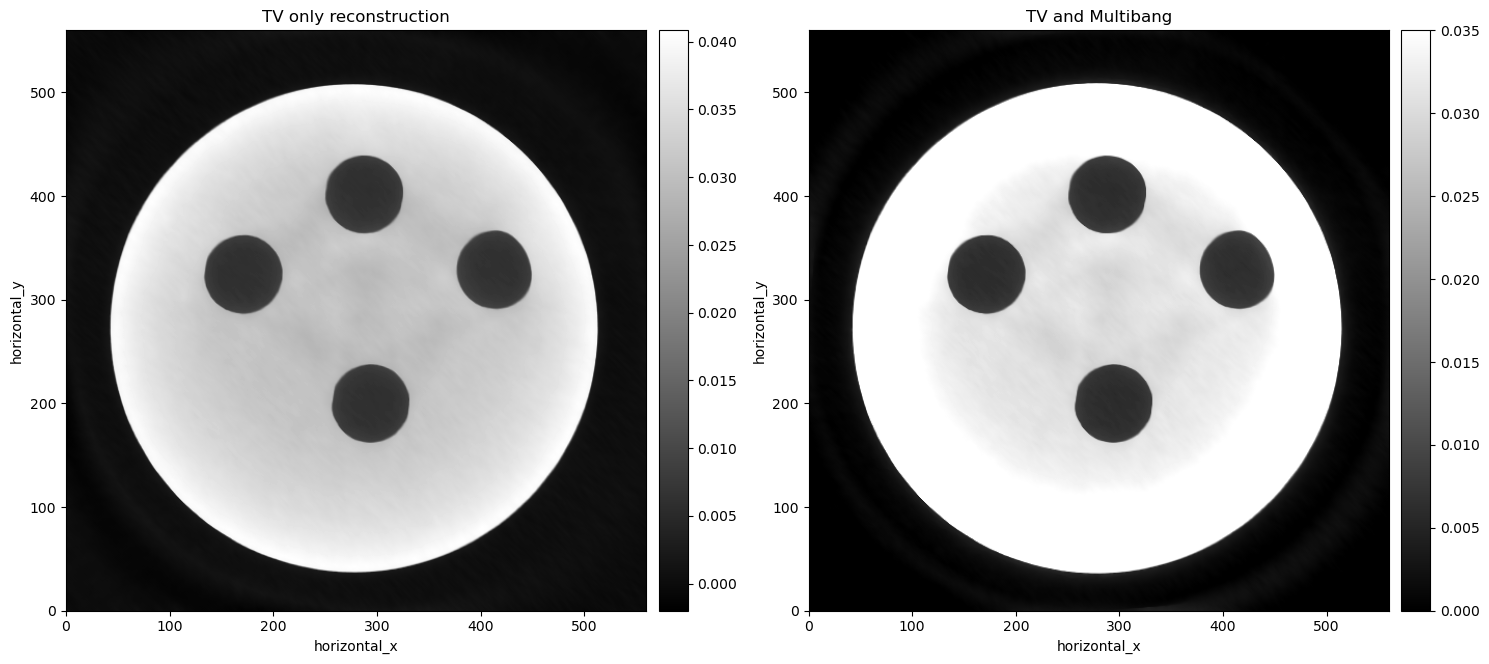

In [ ]:
#Full data reconstruction

#Parameters

alpha = 6
beta = 0.14
epsilon = 0.0001

MB = Multbang(u=np.array([0,0.035]))
f1 = LeastSquares(A=A, b=testdata,c=1.)
f2 = beta * OperatorCompositionFunction(SmoothMixedL21Norm(epsilon), Grad)
F = f1 + f2
G = alpha*MB

initial = ig.allocate(0.0)

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)
fista_mb.run(200,verbose=1)
TVMBsol = fista_mb.solution

G = ZeroFunction()


initial = ig.allocate(0.0)

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)
fista_mb.run(200,verbose=1)
TVsol = fista_mb.solution

show2D([TVsol,TVMBsol],title=['TV only reconstruction','TV and Multibang'])

We use a command copied from the CIL github site to create a new data set containing only a limited angular range.

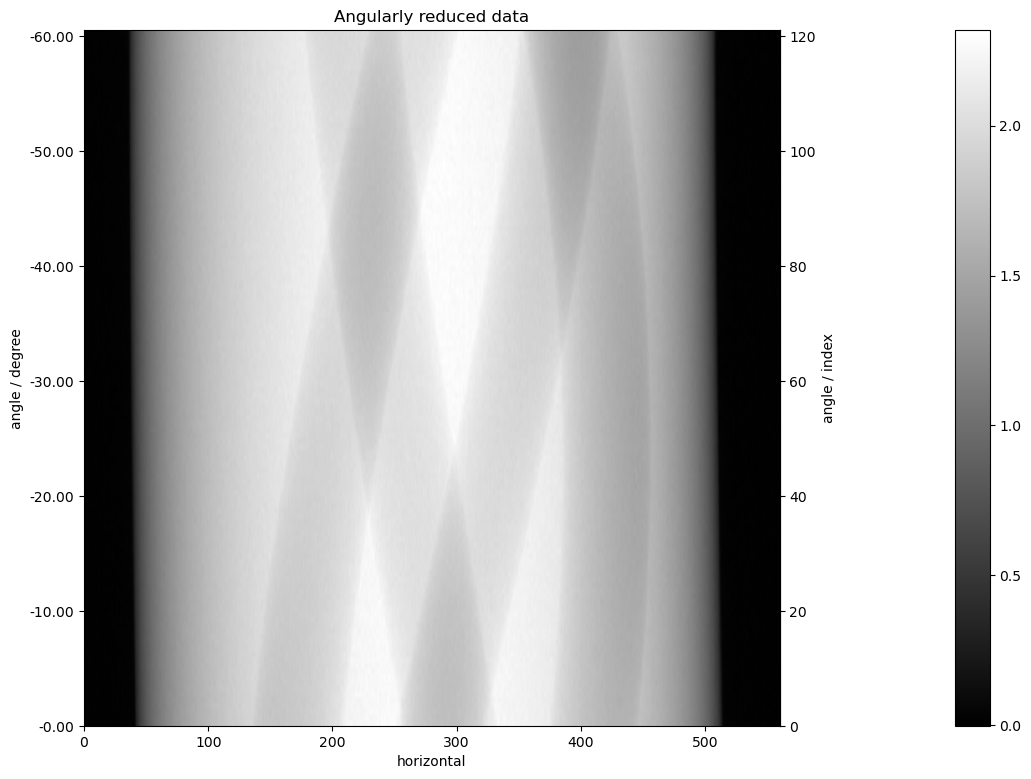

In [ ]:
#Command copied from CIL github

def generate_reduced_data(data, astart, arange):
    idx = [*range(2*astart, 2*(astart+arange)+1)]
    data_array = data.as_array()[idx,:]
    ag_reduced = data.geometry.copy()
    ag_reduced.set_angles(ag_reduced.angles[idx])
    data_reduced = AcquisitionData(data_array, geometry=ag_reduced)
    return data_reduced

#Reduce angles in test data

testdatareduce = generate_reduced_data(testdata,0,60)

show2D(testdatareduce,title=['Angularly reduced data'])

#Reset geometry for reduced htc data

ig = testdatareduce.geometry.get_ImageGeometry()
ag = testdatareduce.geometry
devive="gpu"
A = ProjectionOperator(ig,ag,device)
Grad = GradientOperator(ig)

We now perform the same reconstruction but on the reduced data set. The results are clearly quite different with the multibang detemining more of the shape although also reconstructing the structure incorrectly.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.83778e+05
      100       1000         0.043          3.38524e+02
      200       1000         0.044          2.96341e+02
-------------------------------------------------------
      200       1000         0.044          2.96341e+02
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.83778e+05
      100       1000         0.020          2.14221e+02
      200       1000         0.020          2.18275e+02
-------------------------------------------------------
      200       1000         0.020          2.18275e+02
Stop criterion has been reached.



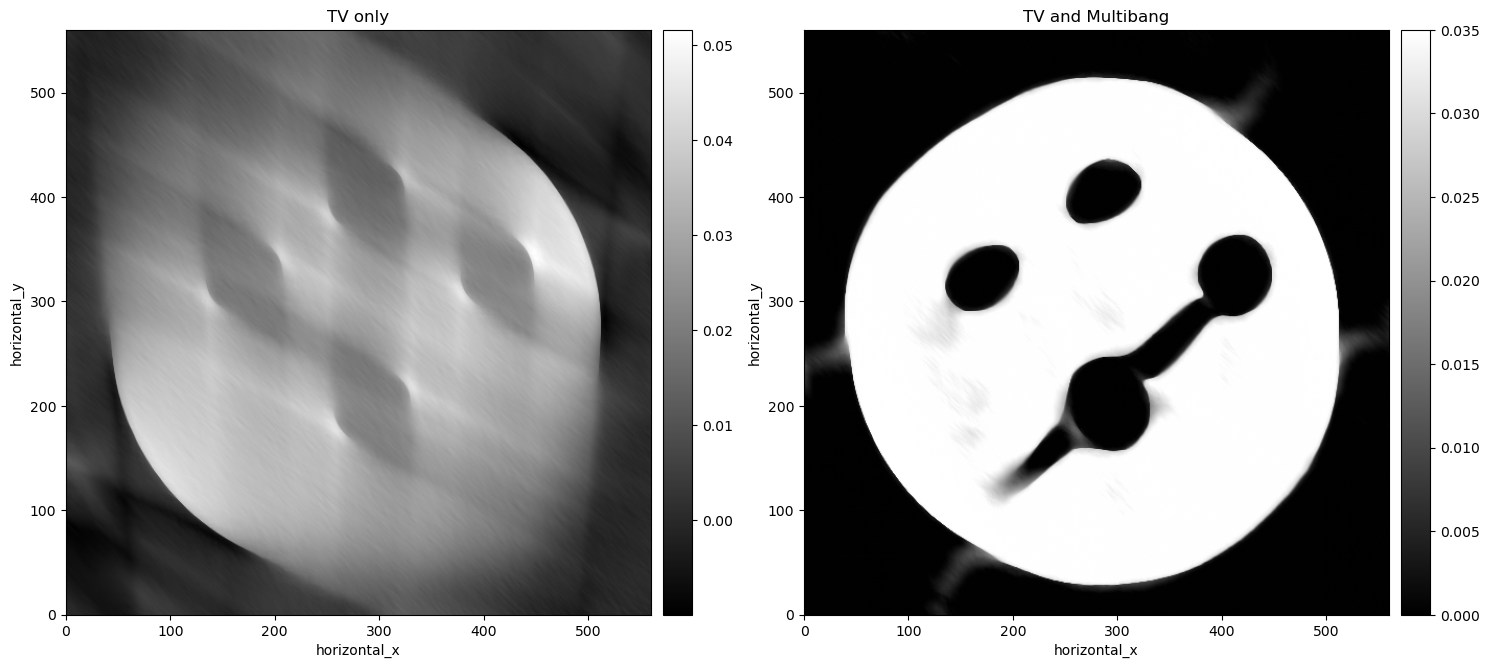

In [ ]:
#Reduced data reconstruction

alpha = 6
beta = 0.14
epsilon = 0.0001

MB = Multbang(u=np.array([0,0.035]))
f1 = LeastSquares(A=A, b=testdatareduce,c=1.)
f2 = beta * OperatorCompositionFunction(SmoothMixedL21Norm(epsilon), Grad)
F = f1 + f2
G = alpha*MB


initial = ig.allocate(0.0)

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)
fista_mb.run(200,verbose=1)
TVMBsol = fista_mb.solution

G = ZeroFunction()

initial = ig.allocate(0.0)

fista_mb = FISTA(f=F,g=G,initial=initial,max_iteration=1000,update_objective_interval=100)
fista_mb.run(200,verbose=1)
TVsol = fista_mb.solution

show2D([TVsol,TVMBsol],title=['TV only','TV and Multibang'])